## Artificial Intelligence Assignment 3
## No2. Classification Learning
## 20132651 Sungjae Lee

In [1]:
## 1번 문제에서의 신경망을 활용하여, 사진을 분류하는 분류기를 생성해 봅니다.
## 1.정규화된 CIFAR-10 훈련집합과 테스트집합을 torchvision을 이용하여 적재합니다.

import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
## torchvision.transform 을 이용하여 사진 데이터를 변형합니다.
## Tensor 데이터로 변환하고, 각 채널에 대해 Normalize 하는 설정을 transform 변수에 저장합니다.

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])


In [3]:
## 위의 설정을 토대로 CIFAR-10 이미지 데이터를 가져옵니다.
## train = True 로 학습 데이터만 가져오며, 데이터가 없다면 다운로드 받습니다.
## trainloader 에 배치 사이즈를 4로 하여 데이터를 나누어 넣습니다.
## num_workers 는 데이터를 로드할 때 몇개의 서브 프로세스들을 사용할 것인지에 대한 설정입니다.

trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=4,
                                          shuffle=False,
                                          num_workers=2)

Files already downloaded and verified


In [4]:
## 위의 학습 데이터를 가져올 때와 마찬가지로 테스트 데이터를 가져옵니다.
## 동일한 방법과 설정으로 테스트 데이터에 대한 데이터로더를 생성합니다.

testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=4,
                                         shuffle=False,
                                         num_workers=2)

Files already downloaded and verified


In [5]:
## CIFAR-10 에서 순서대로 정의된 10개의 레이블을 단어 형태로 작성하여 classes 변수에 넣습니다.
## 레이블을 단어 형태로 출력하기 위해서는 classes 변수에서 꺼내와 사용하게 됩니다.

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### (1) 화면 출력 확인

In [6]:
## 실제 레이블 단어들인 classes가 정상적으로 저장되었는지 출력합니다.

print(classes)

('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [7]:
## 훈련집합의 일부 사진들을 확인하기 위해 matplotlib 패키지를 가져옵니다.

import matplotlib.pyplot as plt
import numpy as np

In [8]:
## 이미지를 출력하기 위한 함수인 imshow 를 정의합니다.
## 위에서 normalize 했던 이미지를 다시 unnormalize 한 다음, numpy 형태로 변환합니다.
## 이미지가 회전된 상태이기 때문에, 정상적으로 볼 수 있도록 np.transpose 로 회전시킵니다.

def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [9]:
## iter를 사용하여 trainloader 에서 1개 배치인 4개의 이미지를 가져와 images 와 labels 에 저장합니다.
## 개수를 확인해 보니 4개의 이미지가 맞으며, labels 에는 각 이미지의 레이블이 번호 형태로 저장되어 있었습니다.

dataiter = iter(trainloader)
images, labels = dataiter.next()
print(len(images))
print(labels)

4
tensor([6, 9, 9, 4])


### (2) 화면 출력 확인

     frog    /    truck    /    truck    /     deer


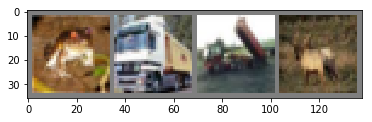

In [10]:
## 위에서 정의한 imshow 함수를 이용하여 뽑아낸 4개의 이미지를 출력합니다.
## 이 때 torchvision 의 make_grid 를 사용하여 이미지를 그리드 형태로 출력합니다.
## 이미지의 레이블을 classes 에서 찾아와 단어 형태로 출력합니다.

imshow(torchvision.utils.make_grid(images))
print('    ' + '    /    '.join('%5s' % classes[labels[j]] for j in range(4)))

In [11]:
## 2. 컨볼루션 신경망을 정의합니다.
## 3채널 32 * 32 크기의 사진을 입력받아, 신경망을 통과해 10개 class 로 분류를 수행하는 신경망입니다.

In [12]:
import torch.nn as nn
import torch.nn.functional as F

In [13]:
## 1번 문제에서와 완전히 동일한 형태의 신경망을 생성합니다.
## conv1 > relu > pooling > conv2 > relu > pooling > view
## > fc1 > relu > fc2 > relu > fc3 > 10개 클래스 분류의 형태입니다.

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [14]:
## 3. 손실함수를 정의하고, 교차 엔트로피와 SGD, momentum 을 사용해 봅니다.

In [15]:
## 손실함수를 pytorch.nn 의 CrossEntropyLoss 를 이용하여 정의내립니다.
## optimizer 는 앞에서와 마찬가지로 optim 의 스토캐스틱 경사하강을 사용합니다.

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### (3) 화면 출력 확인 및 학습이 되고 있는지 서술

In [16]:
## 4. 훈련집합을 이용하여 신경망을 학습시킵니다.

In [17]:
## 2번의 epoch 동안 학습을 진행합니다. 이 때 running loss 를 1000개 데이터 단위로 합산하여 출력합니다.

for epoch in range(2):
    running_loss = 0.0
    
    ## trainloader 에서 index 와 data 를 뽑아내어 학습을 진행합니다.
    for i, data in enumerate(trainloader, 0):
        
        # data 에서 feature 와 labels 를 나눠 저장합니다.
        inputs, labels = data
        
        # optimizer 의 가중치를 0으로 초기화 합니다.
        optimizer.zero_grad()
        
        ## forward(전방전파) + backward(역전파) + optimize(최적화) 과정입니다. 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # 1000개 데이터 단위로 끊어서 loss의 합산을 출력합니다.
        running_loss += loss.item()
        if i % 1000 == 999:
            print('[%d, %5d] loss : %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

## 1번째 epoch 에서는 loss가 2점대 초반에서 1점대 중반으로 감소하였습니다.
## 2번째 epoch 에서는 1번째에 이어서 loss가 1점대 중반에서 1점대 초반으로 감소하였습니다.
## 약간 더딘 속도이긴 하지만 loss 가 꾸준히 줄어드는 것으로 보아 학습의 방향은 적절하다고 할 수 있습니다.

[1,  1000] loss : 2.299
[1,  2000] loss : 2.130
[1,  3000] loss : 1.919
[1,  4000] loss : 1.788
[1,  5000] loss : 1.687
[1,  6000] loss : 1.609
[1,  7000] loss : 1.561
[1,  8000] loss : 1.533
[1,  9000] loss : 1.548
[1, 10000] loss : 1.498
[1, 11000] loss : 1.469
[1, 12000] loss : 1.437
[2,  1000] loss : 1.412
[2,  2000] loss : 1.387
[2,  3000] loss : 1.379
[2,  4000] loss : 1.385
[2,  5000] loss : 1.335
[2,  6000] loss : 1.322
[2,  7000] loss : 1.281
[2,  8000] loss : 1.271
[2,  9000] loss : 1.325
[2, 10000] loss : 1.281
[2, 11000] loss : 1.280
[2, 12000] loss : 1.226
Finished Training


In [18]:
## 5. 테스트 집합을 이용하여 신경망 성능을 확인합니다.

In [19]:
## testloader 에서 1개 배치 이미지들을 뽑아내어 출력해 봅니다.

dataiter = iter(testloader)
images, labels = dataiter.next()

### (4) 화면 출력 확인

GroundTruth:    cat    /     ship    /     ship    /    plane


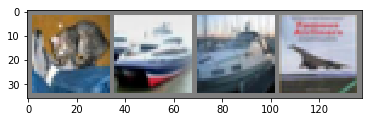

In [20]:
## 앞에서 사용했던 imshow 함수를 이용하여 뽑아낸 테스트 집합의 사진들을 출력해 봅니다.

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ','    /    '.join('%5s'% classes[labels[j]] for j in range(4)))

### (5) 화면 출력 확인

In [21]:
## CNN 을 통해 해당 이미지들을 분류한 결과를 output에 저장합니다.
## 그 다음, 위에서 알아본 이미지의 레이블들과 적절하게 매치되는지 확인합니다.

outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ','    /    '.join('%5s'% classes[predicted[j]] for j in range(4)))

Predicted:    cat    /     ship    /     ship    /    plane


### (6) 화면 출력 확인 및 일반화 성능 서술

In [22]:
## 일부 데이터셋이 아닌 모든 테스트 데이터셋에 대해 예측을 진행합니다.
## 레이블을 맞게 예측한 데이터가 몇 개인지 세기 위해 correct 변수를 0부터 계산합니다.
## 전체 데이터의 개수는 total 변수로 0부터 계산합니다.
## predict한 레이블과 실제 label이 동일한 개수를 세어 correct 에 저장합니다.
## accuracy 는 correct / total 로 계산합니다.

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images :%d %%'%(100 * correct / total))

## 여러 번 시행해본 결과 Accuracy는 50% ~ 60% 정도가 나타났습니다.
## 테스트 데이터에서 상당히 낮은 Accuracy 가 나타나는 것으로 보아
## 해당 모델의 일반화 성능이 좋지 못한 것으로 보입니다.
## 이러한 모델의 일반화 성능을 높이기 위해서는 다양한 기법을 사용할 필요가 있습니다.     
## 예를 들어 더 작은 커널을 깊게 쌓거나, 규제항을 생성하여 일반화 시키는 등의 것입니다.

Accuracy of the network on the 10000 test images :55 %


In [23]:
## 각 클래스별 성능을 알아보기 위한 코드입니다.
## class_correct 와 class_total 을 10개의 값을 갖는 리스트로 생성합니다.
## 각 레이블별로 correct 수와 total 수를 위의 리스트에 저장합니다.

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

### (7) 화면 출력 확인 및 부류별 분류기의 성능 서술

In [24]:
## 각 레이블에 따른 Accuracy 를 출력합니다.
## 높은 성능의 부류는 Ship, Horse, Car 이며
## 낮은 성능의 부류는 Dog, Bird, Cat 입니다.
## 각 부류가 어떤 기준으로 낮은 성능과 높은 성능을 갖는가에 대해서는 잘 모르겠습니다
## (작은 개체, 큰 개체), (생물 개체, 무생물 개체), (털이 날리는 개체, 아닌 개체) 등

for i in range(10):
    print('Accuracy of %5s: %2d %%'%(classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 54 %
Accuracy of   car: 74 %
Accuracy of  bird: 34 %
Accuracy of   cat: 47 %
Accuracy of  deer: 51 %
Accuracy of   dog: 36 %
Accuracy of  frog: 58 %
Accuracy of horse: 73 %
Accuracy of  ship: 75 %
Accuracy of truck: 51 %
